In [1]:
using Pkg
for p in ["Knet", "Plots", "IterTools","PyCall"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, xavier_uniform
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/ec2-user/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


In [20]:
include("utils.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at utils.jl:3
└ @ Core /home/ec2-user/graph_convolutional_networks/gcn/utils.jl:3


In [21]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("nell")

(
  [19982,     1]  =  1
  [41507,     2]  =  1
  [9215 ,     3]  =  1
  [18079,     4]  =  1
  [18081,     4]  =  1
  [21930,     4]  =  1
  [9742 ,     5]  =  1
  [42496,     5]  =  1
  [42504,     5]  =  1
  [42505,     5]  =  1
  [8929 ,     6]  =  1
  [8946 ,     6]  =  1
  ⋮
  [8937 , 65751]  =  1
  [8945 , 65751]  =  1
  [8929 , 65752]  =  1
  [8937 , 65752]  =  1
  [8961 , 65753]  =  1
  [8964 , 65753]  =  1
  [9875 , 65753]  =  1
  [8975 , 65754]  =  1
  [9045 , 65754]  =  1
  [9105 , 65754]  =  1
  [8937 , 65755]  =  1
  [8950 , 65755]  =  1
  [8985 , 65755]  =  1, 
  [1    ,     1]  =  1
  [2    ,     1]  =  1
  [3    ,     1]  =  1
  [6    ,     1]  =  2
  [15   ,     1]  =  1
  [27   ,     1]  =  2
  [30   ,     1]  =  3
  [38   ,     1]  =  1
  [46   ,     1]  =  2
  [59   ,     1]  =  1
  [68   ,     1]  =  2
  [72   ,     1]  =  2
  ⋮
  [61266, 65743]  =  1
  [61267, 65744]  =  1
  [61268, 65745]  =  1
  [61269, 65746]  =  1
  [61270, 65747]  =  1
  [61271, 65748]  =  1

In [22]:
# TODO: take user inputs
struct arg
    epochs
    lr
    weight_decay
    hidden
    pdrop
    window_size
end

arguments = arg(200, 0.01, 1e-5, 64, 0.1, 10)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

function val_loss(g::GCN,x,y)
    output = g(x)[:, idx_val]
    nll(output, y[idx_val]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function val_loss(g::GCN, d)
    mean(val_loss(g,x,y) for (x,y) in d)
end

function test_loss(g::GCN,x,y)
    output = g(x)[:, idx_test]
    nll(output, y[idx_test]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function test_loss(g::GCN,d)
    mean(test_loss(g,x,y) for (x,y) in d)
end

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 

In [23]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

65755-element Array{Int64,1}:
  61
  39
 127
  23
  84
  94
  14
  74
 163
 164
  69
  32
 105
   ⋮
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1

In [24]:
data =  minibatch(features, labels_decoded[:],  length(labels_decoded[:]))

Data{Tuple{SparseMatrixCSC{Int32,Int64},Array{Int64,1}}}(Int32[1 1 … 0 0; 1 4 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [61 39 … 1 1], 65755, 65755, false, 1, 1:65755, false, (61278, 65755), (65755,), SparseMatrixCSC{Int32,Int64}, Array{Int64,1})

In [25]:
function train_with_results(model, data, epoch, lr)
    training = adam(model, ncycle(data, epoch), lr=lr)

    function snapshot()
        out = model(features)
        model(data), val_loss(model, data)
    end
    snapshots = (snapshot() for x in takenth(progress(training),length(data)))
    res = reshape(collect(flatten(snapshots)),(2,:))
    return res
end

train_with_results (generic function with 1 method)

In [30]:
results = train_with_results(model, data, 2, arguments.lr)
trnloss, valloss = Array{Float32}(results[1,:]), Array{Float32}(results[2,:])

┣███████████████████▉┫ [100.00%, 2/2, 13:12/13:12, 395.94s/i] 


(Float32[108.135704, 78.37649], Float32[107.99627, 78.604675])

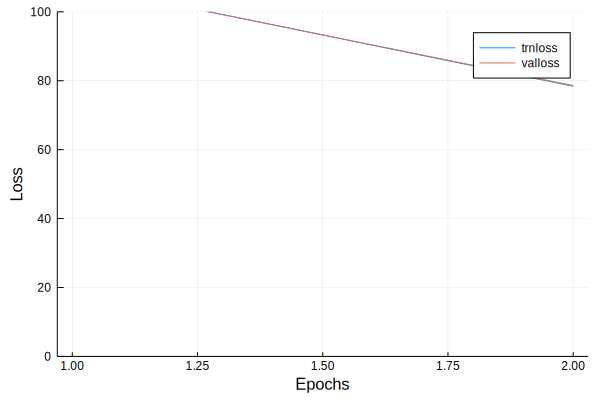

In [31]:
plot([trnloss, valloss], ylim=(0.0,100),labels=[:trnloss :valloss],xlabel="Epochs",ylabel="Loss")

In [32]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.0761904761904762

In [36]:
idx_val

2:106

In [33]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.0761904761904762

In [34]:
png("nell")